# Branching Out into Isolation Forests

### Tree Based Anomaly Detection

Stephanie Kirmer

ChiPy October 2020

In [1]:
import numpy as np
import pandas as pd
import logging as log
import os
import datetime
import typing
from typing import Callable, List
import re
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.palettes import Spectral6, brewer
from bokeh.transform import linear_cmap, factor_cmap

# Load data 

From Kaggle - tracks on Spotify

https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data.csv

Let's identify really unusual tracks!

In [2]:
dataset = pd.read_csv("/Users/skirmer/projects/isolationforests/data/data.csv")

Characteristics of the tracks:

In [3]:
dataset.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

# Feature Engineering

Adding some ratios and scaled versions of some features.

In [4]:
def make_ratios(df: pd.DataFrame, featurenames: List[List]):
    ''' Accepts a list of lists (pairs of columns) to be ratioed. Returns the original dataframe with new columns representing ratios of features appended to end.'''

    for i in featurenames:
        df[f'ratio_{i[0]}_{i[1]}'] = df[i[0]]/df[i[1]]
        log.info('Added new feature:' + f'ratio_{i[0]}_{i[1]}')
    return(df)

In [5]:
dataset2 = make_ratios(dataset, featurenames = [['energy', 'acousticness'], ['loudness', 'acousticness'], ['loudness', 'tempo'], ['instrumentalness', 'speechiness']])

In [6]:
dataset2 = dataset2.replace([np.inf, -np.inf], 0)


def scale_all_features(df: pd.DataFrame):
    rdf = df.select_dtypes(include='number')
    rdf2 = pd.DataFrame(minmax_scale(rdf))
    rdf2.columns = [f'{x}_scaled' for x in rdf.columns]
    rdf3 = pd.concat([df.reset_index(drop=True), rdf2], axis=1)
    return(rdf3)

dataset2 = scale_all_features(dataset2)

dataset2['year_bin'] = pd.cut(dataset2['year'],9)

In [7]:
dataset2[['energy', 'energy_scaled']].head()

energy  energy_scaled
0  0.1950         0.1950
1  0.0135         0.0135
2  0.2200         0.2200
3  0.1300         0.1300
4  0.2040         0.2040

In [8]:
dataset2['year_bin'].value_counts(normalize=True) * 100


(1998.0, 2009.0]      12.948108
(1987.0, 1998.0]      12.948108
(1976.0, 1987.0]      12.948108
(1965.0, 1976.0]      12.948108
(1954.0, 1965.0]      12.948108
(2009.0, 2020.0]      12.745646
(1943.0, 1954.0]      11.576197
(1932.0, 1943.0]       6.598826
(1920.901, 1932.0]     4.338793
Name: year_bin, dtype: float64

In [9]:
from plotnine import *
import plotnine.options as pn
from bokeh.plotting import output_file, show

pn.figure_size = (7,3)
# Must downsample to get any reasonable rendering speed
plotset = dataset2.sample(frac=0.25, replace=False, random_state=1)


Loading BokehJS ...

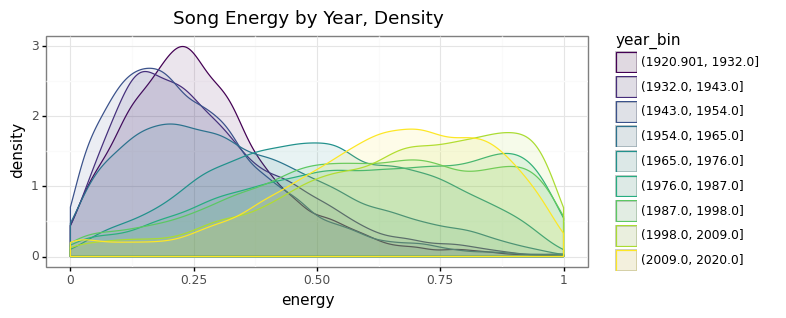

<ggplot: (314649381)>

In [10]:

output_notebook() 

(
    ggplot(plotset, aes(x='energy', color='year_bin', fill='year_bin'))
    + theme_bw()
    + geom_density(alpha=0.1)
    +labs(title = "Song Energy by Year, Density")
)


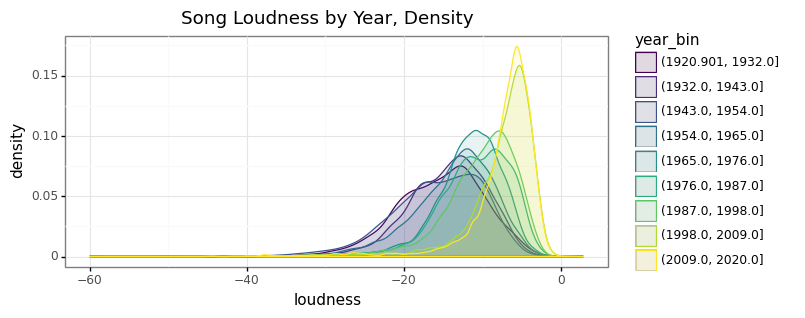

<ggplot: (321956289)>

In [11]:
(
    ggplot(plotset, aes(x='loudness', color='year_bin', fill='year_bin'))
    + theme_bw()
    + geom_density(alpha=0.1)
    +labs(title = "Song Loudness by Year, Density")
)

In [12]:
features = ['acousticness', 'danceability', 'duration_ms', 
            'energy', 'explicit', 'instrumentalness', 
            'key', 'liveness', 'loudness', 'mode', 'popularity',
            'speechiness', 'tempo', 'valence', 'year', 'ratio_energy_acousticness',
            'ratio_loudness_acousticness', 'ratio_loudness_tempo',
            'ratio_instrumentalness_speechiness']

# Model Training

In [26]:

def fit_model(dataframe, feature_list):
    ''' Accepts dataframe and list of features to be used in model training. 
    Returns trained model object and dataset with NAs removed and anomalousness 
    features appended. '''
    rng = np.random.RandomState(42)
    nd = dataframe.dropna()
    #nd = dataframe.fillna(value=0)
    X_train2 = nd.loc[:,feature_list]
    clf = IsolationForest(n_estimators=100, max_features=3,
                          contamination=.03, random_state=rng)
    clf.fit(X_train2)
    decfn = clf.decision_function(X_train2)
    scores = clf.score_samples(X_train2) 

    y_pred_train = clf.predict(X_train2)
    X_train2.loc[:,'preds'] = y_pred_train
    X_train2.loc[:,'preds_txt'] = X_train2.loc[:,'preds'].replace({-1:"Anomaly", 1: "Normal"})

    X_train2.loc[:,'decision_fn'] = decfn
    X_train2.loc[:,'scores'] = scores
    X_train2.loc[:,'year_bin'] = nd.loc[:,'year_bin']
    return(clf, X_train2)


In [14]:

def predict_on_new(newdata, feature_list, modelobj):
    ''' Accepts dataframe, trained model object, and list of features required by model. 
    Returns dataset with NAs removed and anomalousness features appended. '''
    nd = newdata.dropna()
#     #newdata.fillna(value=0, inplace=True)
    dataframe = nd.loc[:, feature_list]
    decfn = modelobj.decision_function(dataframe)
    scores = modelobj.score_samples(dataframe)

    y_pred_test = modelobj.predict(dataframe)
    dataframe.loc[:,'preds'] = y_pred_test
    dataframe.loc[:,'preds_txt'] = dataframe.loc[:,'preds'].replace({-1:"Anomaly", 1: "Normal"})

    dataframe.loc[:,'decision_fn'] = decfn
    dataframe.loc[:,'scores'] = scores
    dataframe.loc[:,'year_bin'] = nd.loc[:,'year_bin']
    
    return(dataframe)

In [15]:

X_train, X_test = train_test_split(dataset2, test_size=0.3)


In [16]:
modobj, new_X_train= fit_model(X_train, features)


In [17]:
new_X_train.head()

acousticness  danceability  duration_ms  energy  explicit  \
104059      0.000028         0.234       181320   0.693         0   
87476       0.835000         0.609       233720   0.378         0   
93021       0.612000         0.593       201427   0.368         0   
148635      0.089600         0.301       367987   0.498         0   
131395      0.366000         0.803       315880   0.909         0   

        instrumentalness  key  liveness  loudness  mode  ...  year  \
104059           0.89900    0    0.4420    -8.277     1  ...  1988   
87476            0.00000    4    0.2800    -9.828     1  ...  2015   
93021            0.00000    9    0.0905   -12.257     1  ...  1972   
148635           0.07740    0    0.6880    -9.769     1  ...  1977   
131395           0.00901   11    0.0831    -6.039     0  ...  1979   

        ratio_energy_acousticness  ratio_loudness_acousticness  \
104059               24574.468085               -293510.638298   
87476                    0.452695                   -11.770060   
93021                    0.601307                   -20.027778   
148635                   5.558036                  -109.029018   
131395                   2.483607                   -16.500000   

        ratio_loudness_tempo  ratio_instrumentalness_speechiness  preds  \
104059             -0.077404                           22.034314      1   
87476              -0.097871                            0.000000      1   
93021              -0.095163                            0.000000      1   
148635             -0.055022                            2.411215      1   
131395             -0.045345                            0.184254      1   

        preds_txt  decision_fn    scores          year_bin  
104059     Normal     0.001517 -0.535772  (1987.0, 1998.0]  
87476      Normal     0.084712 -0.452577  (2009.0, 2020.0]  
93021      Normal     0.134848 -0.402441  (1965.0, 1976.0]  
148635     Normal     0.036784 -0.500506  (1976.0, 1987.0]  
131395     Normal     0.079834 -0.457455  (1976.0, 1987.0]  

[5 rows x 24 columns]

# Predict on Test Holdout

In [18]:
new_X_test = predict_on_new(newdata=X_test, feature_list=features, modelobj=modobj)
new_X_test.head()

acousticness  danceability  duration_ms  energy  explicit  \
5476        0.136000         0.420       374533   0.683         0   
76121       0.000112         0.483        90427   0.979         0   
95264       0.073000         0.496       272240   0.576         0   
169420      0.122000         0.836       193271   0.684         1   
164542      0.113000         0.294       316067   0.444         0   

        instrumentalness  key  liveness  loudness  mode  ...  year  \
5476            0.006240   10    0.1090    -7.168     0  ...  1994   
76121           0.000000    7    0.2540    -3.543     1  ...  2001   
95264           0.000277    0    0.1010   -12.260     1  ...  1995   
169420          0.000000   11    0.0854    -5.818     1  ...  2016   
164542          0.029200    6    0.1760    -9.649     0  ...  1967   

        ratio_energy_acousticness  ratio_loudness_acousticness  \
5476                     5.022059                   -52.705882   
76121                 8741.071429                -31633.928571   
95264                    7.890411                  -167.945205   
169420                   5.606557                   -47.688525   
164542                   3.929204                   -85.389381   

        ratio_loudness_tempo  ratio_instrumentalness_speechiness  preds  \
5476               -0.050257                            0.105763      1   
76121              -0.038925                            0.000000      1   
95264              -0.102207                            0.007869      1   
169420             -0.038528                            0.000000      1   
164542             -0.058942                            0.813370      1   

        preds_txt  decision_fn    scores          year_bin  
5476       Normal     0.092418 -0.444871  (1987.0, 1998.0]  
76121      Normal     0.067646 -0.469643  (1998.0, 2009.0]  
95264      Normal     0.121176 -0.416113  (1987.0, 1998.0]  
169420     Normal     0.047957 -0.489333  (2009.0, 2020.0]  
164542     Normal     0.074005 -0.463284  (1965.0, 1976.0]  

[5 rows x 24 columns]

# Analyze Predictions


In [19]:
new_X_test['preds'].value_counts(normalize=True) * 100

 1    96.976178
-1     3.023822
Name: preds, dtype: float64

In [20]:
new_X_train['preds'].value_counts(normalize=True) * 100

 1    96.999613
-1     3.000387
Name: preds, dtype: float64

In [21]:
output_notebook() 
# create a new plot with a title and axis labels
p = figure(title="Training Sample Score", y_axis_label='Anomalousness Score', x_axis_label='Tempo, bpm', width=700, height = 300)

source = ColumnDataSource(data=dict(x=new_X_train['tempo'], 
                                y=new_X_train['scores'], 
                                ur = new_X_train['preds_txt'],
                                legend_group= new_X_train['preds_txt']))

colors = factor_cmap('ur', palette=Spectral6, factors=new_X_train.preds_txt.unique()) 

p.circle(color=colors, legend_group = 'legend_group', source=source, fill_alpha=.5, line_alpha = .5)

# show the results
show(p)

Loading BokehJS ...

In [22]:
output_notebook() 
# create a new plot with a title and axis labels
p = figure(title="Test Sample Score", y_axis_label='Anomalousness Score', x_axis_label='Tempo, bpm', width=700, height = 300)

source = ColumnDataSource(data=dict(x=new_X_test['tempo'], 
                                y=new_X_test['scores'], 
                                ur = new_X_test['preds_txt'],
                                legend_group= new_X_test['preds_txt']))

colors = factor_cmap('ur', palette=Spectral6, factors=new_X_test.preds_txt.unique()) 

p.circle(color=colors, legend_group = 'legend_group', source=source)

# show the results
show(p)

Loading BokehJS ...

# Examine Anomalous Songs

In [23]:
anoms = new_X_test[new_X_test['preds_txt'] == 'Anomaly']

In [25]:
pd.crosstab(new_X_test['preds_txt'], new_X_test['year_bin'])


year_bin   (1920.901, 1932.0]  (1932.0, 1943.0]  (1943.0, 1954.0]  \
preds_txt                                                           
Anomaly                   195               216               243   
Normal                   2005              3135              5708   

year_bin   (1954.0, 1965.0]  (1965.0, 1976.0]  (1976.0, 1987.0]  \
preds_txt                                                         
Anomaly                  81                43               162   
Normal                 6524              6506              6488   

year_bin   (1987.0, 1998.0]  (1998.0, 2009.0]  (2009.0, 2020.0]  
preds_txt                                                        
Anomaly                 201               164               236  
Normal                 6415              6377              6263